In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

## Reading the Dataset

In [2]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res  
Cnames_1={0:'Team_W/L',1:'ClusterID',2:'GameMode',3:'GameType'}
Cnames_2={i+4:("Charc_" + str(i)) for i in range(0,114)}
Cnames=Merge(Cnames_1,Cnames_2)

In [3]:
os.chdir("F:/Datasets/Dota/Dota/dota2Dataset")
data=(pd.read_csv("dota2Train.csv",sep=",",header=None))

In [4]:
data.rename(columns=Cnames,inplace=True)
data.tail()

,Team_W/L,ClusterID,GameMode,GameType,Charc_0,Charc_1,Charc_2,Charc_3,Charc_4,Charc_5,...,Charc_103,Charc_104,Charc_105,Charc_106,Charc_107,Charc_108,Charc_109,Charc_110,Charc_111,Charc_112
92645,-1,154,2,3,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,-1,185,2,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
92649,-1,204,2,2,0,-1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

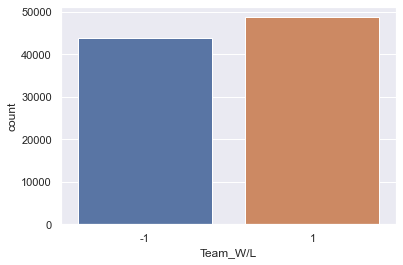

In [5]:
sns.set(style="darkgrid")
sns.countplot(x="Team_W/L", data=data)

Note: There is no class imbalance as both classes are almost at par.

#### Checking for characters that have not been used

In [6]:
dummy=list(data.iloc[:,4:117].columns)
total_zero={}
res={}
total_zero_0={dummy[0]:data[dummy[0]][data[dummy[0]]==0].count()}
total_zero_1={dummy[1]:data[dummy[1]][data[dummy[1]]==0].count()}
res = {**total_zero_0, **total_zero_1} 

    

In [7]:
for i in range(2,len(dummy)):
    total_zero={dummy[i]:data[dummy[i]][data[dummy[i]]==0].count()}
    res = {**res, **total_zero} 
    

In [8]:
from operator import itemgetter
dict_zeros=sorted(res.items(), key=itemgetter(1),reverse=True)
dict_zeros[0:10]

[('Charc_23', 92650),
 ('Charc_107', 92650),
 ('Charc_65', 91860),
 ('Charc_91', 91762),
 ('Charc_77', 91092),
 ('Charc_79', 91075),
 ('Charc_90', 91058),
 ('Charc_112', 90859),
 ('Charc_60', 90690),
 ('Charc_106', 90397)]

#### Chi-squared test

In [9]:
list=(data.columns)
res={}
alpha = 0.05
def chiSq(table): 
            stat, p, dof, expected = chi2_contingency(table)
            return p
df_1 = pd.crosstab(data[list[1]],data['Team_W/L'],margins = False)
df_2 = pd.crosstab(data[list[2]],data['Team_W/L'],margins = False)

res_1={list[1]:chiSq(df_1)}
res_2={list[2]:chiSq(df_2)}

res = {**res_1, **res_2} 

        

In [10]:
result={}
for i in range(2,len(list)):
    df_3 = pd.crosstab(data[list[i]],data['Team_W/L'],margins = False)
    alpha = 0.05
    def chiSq(table): 
            stat, p, dof, expected = chi2_contingency(table)
            return p
    result={list[i]:chiSq(df_3)}
    res = {**res, **result}
    rejected = { key:value for key, value in res.items() if value > alpha }

In [31]:
res

{'ClusterID': 0.2801948074705347,
 'GameMode': 7.200444007296861e-08,
 'GameType': 0.6999475779550306,
 'Charc_0': 6.798104643927504e-15,
 'Charc_1': 5.4412877064967465e-14,
 'Charc_2': 1.9015799862385712e-06,
 'Charc_3': 0.11799541695772105,
 'Charc_4': 3.1033111529440887e-21,
 'Charc_5': 2.22395860177313e-23,
 'Charc_6': 0.7112786296404611,
 'Charc_7': 0.3405044584203592,
 'Charc_8': 8.816428244752192e-80,
 'Charc_9': 0.9048814661030045,
 'Charc_10': 7.247357471797806e-09,
 'Charc_11': 4.5205272329969343e-13,
 'Charc_12': 8.318458302186581e-11,
 'Charc_13': 2.0677528010132397e-12,
 'Charc_14': 7.833699963174991e-05,
 'Charc_15': 0.7359737229542145,
 'Charc_16': 0.008869620963721509,
 'Charc_17': 8.283872583486247e-27,
 'Charc_18': 2.6227644512616834e-18,
 'Charc_19': 0.00011297635146127683,
 'Charc_20': 9.961217862215532e-53,
 'Charc_21': 3.113453562523993e-19,
 'Charc_22': 0.10344435773516263,
 'Charc_23': 1.0,
 'Charc_24': 5.595246529337888e-25,
 'Charc_25': 2.8028955012734053e-06,

## Model Creation

In [11]:
data_pas=data
#data_pas=data.drop(rejected.keys(),axis=1)
#data_pas.head()

In [12]:
data_pas_copy=data_pas

In [13]:
data_pas[data_pas['Team_W/L']== -1]=0
data_pas

,Team_W/L,ClusterID,GameMode,GameType,Charc_0,Charc_1,Charc_2,Charc_3,Charc_4,Charc_5,...,Charc_103,Charc_104,Charc_105,Charc_106,Charc_107,Charc_108,Charc_109,Charc_110,Charc_111,Charc_112
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_pas.iloc[:,1:117] , data_pas.iloc[:,0],test_size=0.2, random_state=0)

In [24]:
############# Logistic regression ##############

In [25]:
from sklearn.linear_model import LogisticRegression
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

### Evalution

Accuracy:  1.0


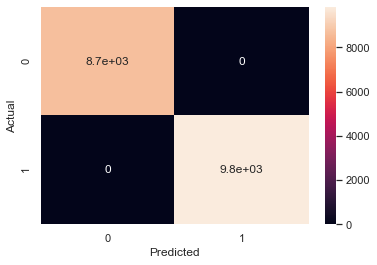

In [29]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

In [33]:
import pickle
import os
os.chdir("F:/Datasets/Dota/Dota") 
Filename = "Dota_model.pkl"  

with open(Filename, 'wb') as file:  
    pickle.dump(logistic_regression, file)